# Проект - анализ данных игрового мобильного приложения

## Содержание

- **[Постановка задачи](#Постановка-задачи)**
- **[0. Импорт библиотек и собственные функции](#0.-Импорт-библиотек-и-собственные-функции)**
- **[1. Рассчет Retention игроков](#1.-Рассчет-Retention-игроков)**
    - [1.1 Найдем для каждого пользователя дни(и их количество), в которые он заходил в игру](#1.1-Найдем-для-каждого-пользователя-дни(и-их-количество),-в-которые-он-заходил-в-игру)
    - [1.2 Найдем общий Retention](#1.2-Найдем-общий-Retention)
    - [1.3 Найдем Retention в важные дни для какого-то промежутка времени](#1.3-Найдем-Retention-в-важные-дни-для-какого-то-промежутка-времени)
- **[2. Оценка результатов A/B теста различных наборов акционных предложений](#2.-Оценка-результатов-A/B-теста-различных-наборов-акционных-предложений)**
    - [2.1 Основные метрики для этого A/B теста](#2.1-Основные-метрики-для-этого-A/B-теста)
    - [2.2 Гипотеза о равенстве средних revenue со всех пользователей(ARPU)](#2.2-Гипотеза-о-равенстве-средних-revenue-со-всех-пользователей(ARPU))
    - [2.3 Гипотеза о равенстве средних revenue с платящих пользователей(ARPPU)](#2.3-Гипотеза-о-равенстве-средних-revenue-с-платящих-пользователей(ARPPU))
    - [2.4 Гипотеза о равенстве квантилей ARPPU](#2.4-Гипотеза-о-равенстве-квантилей-ARPPU)
    - [2.5 Гипотеза о равенстве CR в покупателя](#2.5-Гипотеза-о-равенстве-CR-в-покупателя)
    - [2.6 Выводы и теории](#2.6-Выводы-и-теории)
- **[3. Выбор метрик для оценки результатов тематических ежемесячных событий](#3.-Выбор-метрик-для-оценки-результатов-тематических-ежемесячных-событий)**

## Постановка задачи

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.     
Или точнее:

> _1. Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)._

> _2. Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?_

> _3. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события? Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?_

## Данные

#### Задание 1 
`reg_data.csv` – информация о регистрации пользователей:

| |                                                                               |
| :----------------| :-------------------------------------------------------------------------------------|
| reg_ts           | время регистрации в формате total_seconds                                             |
| uid              | идентификатор пользователя                                                            |
 
`auth_data` – информация заходах пользователей в приложение:

| |                                                                               |
| :----------------| :-------------------------------------------------------------------------------------|
| auth_ts          | время аутентификации в формате total_seconds                                          |
| uid              | идентификатор пользователя                                                            |

#### Задание 2

`task_a_b.csv` - имем файл с результатами A/B теста:е:

| |                                                                               |
| :----------------| :-------------------------------------------------------------------------------------|
| user_id          | идентификатор пользователя                                                            |
| revenue          | доход с пользователя                                                                  |
| testgroup        | лейбл группы - a или b                                                                |


## 0. Импорт библиотек и собственные функции

Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

from datetime import datetime
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Собственные используемые функции:

In [2]:
def arr_day_ret(df):
    '''Функция для нахождения для каждого пользователя дней(и их количества), в которые он заходил в игру'''
    df_arr_days = df.groupby('uid').n_day.apply(list).to_frame().reset_index()
    df_arr_days['count_days'] = df_arr_days.n_day.apply(lambda x: len(x))
    return df_arr_days.sort_values('count_days',ascending=False)

In [3]:
def total_ret(df, zero_day, last_day, roll=False):
    '''Функция для нахождения количества пользователей, которые за все время
       возвращалось на n день для n из промежутка [zero_day, last_day])
       Или аналогичный rolling retention'''
    ret = []
    for i in range(zero_day, last_day+1):
        if not roll:
            n_day_users = df.query('n_day == @i').uid.nunique()
        else:
            n_day_users = df.query('n_day >= @i').uid.nunique()
        ret.append(round(n_day_users / 1000000 * 100, 2))    
    return ret

In [4]:
def ret_dat(df, zero_data, last_data, req_dat=[1, 3, 7, 14, 30, 180],  roll=False):
    '''Функция для нахождения retention в нужные дни - массив дней req_dat для людей,
    зарегистрировавшихся в какой-то промежуток времени из zero_data - last_data'''
    ret_req_dat = []
    df_data = df.query("@zero_data <= reg_ymd <= @last_data")
    cnt_reg_data = df_data.uid.nunique()
    for i in req_dat:
        if not roll:
            n_day_users = df_data.query('n_day == @i').uid.nunique()
        else:
            n_day_users = df_data.query('n_day >= @i').uid.nunique()
        ret_req_dat.append(round(n_day_users / cnt_reg_data * 100, 2))
    return ret_req_dat

In [5]:
def ret_year(df, zero_year, last_year, roll=False, cnt=False):
    '''Функция для нахождения retention по годам - для каждого года считаем retention на дни из req_dat
        roll - rolling retention или обычный, cnt - нужно ли кроме процента выводить количество пользователей'''
    years = list(map(lambda x: str(x)+'-01-01', [i for i in range(zero_year, last_year+2)]))
    all_arr = []
    cnt_reg_year = []
    req_dat=[1, 3, 7, 14, 30, 180]
    
    for i in tqdm(req_dat):
        i_arr = []
        for j in range(len(years)-1):
            a, b = years[j], years[j+1]
            df_data = df.query("@a <= reg_ymd < @b")
            cnt_reg_data = df_data.uid.nunique()
            
            if not roll:
                n_day_users = df_data.query('n_day == @i').uid.nunique()
            else:
                n_day_users = df_data.query('n_day >= @i').uid.nunique()

            if not cnt:
                i_arr.append(round(n_day_users / cnt_reg_data * 100, 2))
            else:
                i_arr.append([round(n_day_users / cnt_reg_data * 100, 2), n_day_users])
           
            if i == req_dat[0]: 
                    cnt_reg_year.append(cnt_reg_data)
                
        all_arr.append(i_arr)
        
    return pd.DataFrame({'years'  : [i for i in range(zero_year, last_year+1)],
                         'cnt_reg': cnt_reg_year,
                         '1_day'  : all_arr[0],
                         '3_day'  : all_arr[1],
                         '7_day'  : all_arr[2],
                         '14_day' : all_arr[3],
                         '30_day' : all_arr[4],
                         '180_day': all_arr[5]})

In [6]:
def get_bootstrap(data_column_1, data_column_2,
                  statistic = np.mean, n_quant = 0.5,
                  boot_it = 1000):
    '''Функция для генерации бутрэп-распределений'''
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): 
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        if statistic == np.quantile:
            boot_data.append(statistic(samples_1 - samples_2, n_quant))
        else:
            boot_data.append(statistic(samples_1 - samples_2))
    return boot_data

In [7]:
def get_pvalue(boot_data):
    '''Функция нахождения pvalue по бутстрапированной разности статистик'''
    p_1 = norm.cdf(x = 0, loc =  np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    return p_value

In [8]:
def plot_ci(pd_boot_data, bootstrap_conf_level = 0.95):
    '''Функция для наглядного изображения гистограммы распределения и границ ci - доверительных интервалов'''
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd.DataFrame(pd_boot_data).quantile([left_quant, right_quant])
    
    plt.hist(pd_boot_data, bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')

In [9]:
def quan_arppu(data_column_1,data_column_2,
               need_quant=[0.05, 0.2, 0.4, 0.5, 0.6, 0.8, 0.95], boot_it = 1000):
    '''Функция для нахождения распределений разницы бутстрапированных квантилей ARPPU'''
    quant = dict()
    for i in need_quant:
        quant['q_' + str(i)] = get_bootstrap(data_column_1, data_column_2,
                                        statistic = np.quantile, n_quant = i, boot_it = boot_it)
        
    return pd.DataFrame.from_dict(quant)

In [10]:
def boot_q():
    '''Функция строит боксплоты по бутсрап. данным квантилей ARPPU'''
    sns.set(rc={'figure.figsize':(15, 4)})
    f, (ax1, ax2) = plt.subplots(1, 2)
    sns.boxplot(data=q[['q_0.05', 'q_0.2', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.8']], ax=ax1)
    sns.boxplot(data=q[['q_0.95']].loc[q['q_0.95'] > 25000], ax=ax2)
    ax1.set_title('Доверительный интервал разницы')
    ax2.set_title('Доверительный интервал разницы')
    ax1.set_ylabel('Отклонение разницы от нуля')
    ax2.set_ylabel('Отклонение разницы от нуля')
    ax1.set_xlabel('diff_boot_quant_a_b')
    ax2.set_xlabel('diff_boot_quant_a_b')

## 1. Рассчет Retention игроков
[Содержание](#Содержание)

Считаем и взглянем на данные:

In [11]:
reg_data = pd.read_csv('reg_data.csv', sep=';')
auth_data = pd.read_csv('auth_data.csv', sep=';')

In [12]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [13]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [14]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [15]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [16]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Пропущенных значений не наблюдается, приведем дату к удобному формату       
Забавно, что в мобильной игре были регистрации, начиная с 1998 года(что-то подсказывает, что данные не мобильной игры :) )

In [17]:
auth_data['auth_ymd'] = pd.to_datetime(auth_data.auth_ts.apply(lambda x : datetime.fromtimestamp(x).strftime('%Y-%m-%d')))
reg_data['reg_ymd'] = pd.to_datetime(reg_data.reg_ts.apply(lambda x : datetime.fromtimestamp(x).strftime('%Y-%m-%d')))

In [18]:
auth_data[['uid', 'auth_ymd']].head()

,uid,auth_ymd
0,1,1998-11-18
1,2,1999-07-23
2,2,1999-07-25
3,2,1999-07-31
4,2,1999-08-05


Соединим два фрэйма, чтобы подсчитать количество дней с момента регистарции на момент каждой аутентификации

In [19]:
df_1 = auth_data[['uid', 'auth_ymd']].merge(reg_data[['uid', 'reg_ymd']], how='left', on='uid')

Проверка - уточнил, что у меня данные уже по заходам пользователя не больше раза в день(чтобы лишнее не считать)

In [20]:
df_1.shape[0] == df_1.groupby(['uid', 'auth_ymd']).agg({'reg_ymd':'count'}).shape[0]

True

In [21]:
df_1['n_day'] = (df_1.auth_ymd - df_1.reg_ymd)

In [22]:
df_1.n_day = df_1.n_day.apply(lambda x: x.days)

In [23]:
df_1.head()

,uid,auth_ymd,reg_ymd,n_day
0,1,1998-11-18,1998-11-18,0
1,2,1999-07-23,1999-07-23,0
2,2,1999-07-25,1999-07-23,2
3,2,1999-07-31,1999-07-23,8
4,2,1999-08-05,1999-07-23,13


Найдем, все ли пользователи заходили в игру сразу(в тот же день) после регистрации - да,  число совпадает с количеством регистраций

In [24]:
reg_data.uid.nunique()

1000000

In [25]:
df_1.query('n_day == 0').uid.nunique()

1000000

### 1.1 Найдем для каждого пользователя дни(и их количество), в которые он заходил в игру   

(Детальный взгляд на каждого, можно точно проследить retention самых больших фанатов или отдельных игроков(групп игроков))

In [26]:
arr_day_ret(df_1).head()

,uid,n_day,count_days
1,2,"[0, 2, 8, 13, 19, 22, 26, 28, 34, 38, 41, 42, ...",1929
99,108,"[0, 2, 9, 11, 17, 23, 24, 30, 31, 34, 40, 46, ...",1397
148,158,"[0, 3, 5, 9, 15, 16, 18, 19, 22, 25, 28, 34, 3...",1367
163,176,"[0, 6, 12, 14, 17, 24, 25, 26, 33, 35, 40, 47,...",1331
175,191,"[0, 3, 8, 9, 15, 18, 25, 28, 30, 31, 37, 40, 4...",1296


### 1.2 Найдем общий Retention  

Процент пользователей, возвращающихся в конкретные дни с 0 по 10

In [27]:
total_ret(df_1, 0, 10, roll=False)

[100.0, 2.01, 4.11, 4.61, 5.24, 5.97, 6.84, 5.81, 4.75, 4.99, 5.08]

Аналогичный rolling retention для дней с 0 по 10

In [28]:
total_ret(df_1, 0, 10, roll=True)

[100.0, 23.84, 23.67, 23.32, 22.93, 22.46, 21.94, 21.33, 20.8, 20.36, 19.88]

Визуализируем общий обычный retention первых 60 дней

Text(0, 0.5, '% пользователей, вернувшихся в n-ый день')

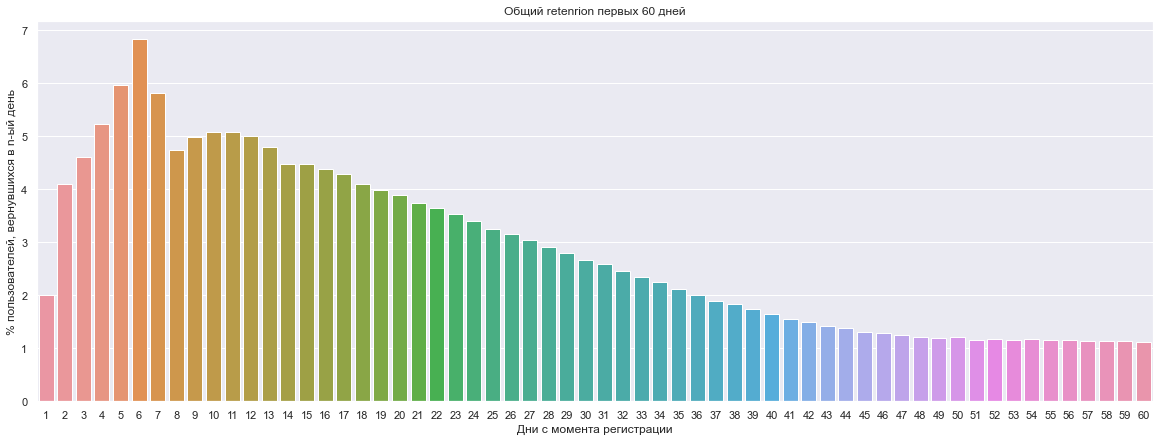

In [29]:
sns.set(rc={'figure.figsize':(20,7)})

ax = sns.barplot(x=[i for i in range(1, 61)], y=total_ret(df_1, 1, 60, roll=False))
ax.set_title('Общий retenrion первых 60 дней')
ax.set_xlabel('Дни с момента регистрации')
ax.set_ylabel('% пользователей, вернувшихся в n-ый день')

### 1.3 Найдем Retention в важные дни для какого-то промежутка времени

Можно для любой даты регистрации найти Retention для самых нужных n - возьмем для примера 1, 3, 7, 14, 30, 60, 180 дни.
Но так как в среднем в день у нас бывает не так много регистраций:

In [30]:
df_1.groupby('reg_ymd').agg({'uid':'count'}).rename(columns={'uid': 'n_uniq_reg'}).describe()

,n_uniq_reg
count,5110.000000
mean,1878.867515
std,2165.565142
min,1.000000
25%,8.000000
50%,874.500000
75%,3579.750000
max,7933.000000


Итого, напишем функцию для подсчета Retention в [1, 3, 7, 14, 30, 60, 180] дни для какого-то промежутка времени        
(Можно поменять один знак и тогда уже это будет rolling retention - удержание на n день или любой другой после него, тоже вещь полезная, особенно для инвесторов :) ) + Можно сравнивать промежутки между собой(например после проведения А/B теста, чтобы потом генерировать/начинать более подробно проверять гипотезы)

Получили показатели Retention для [1, 3, 7, 14, 30, 60, 180] дней для пользователей, зарегистировавшихся в сентябре 2010 года

In [31]:
ret_dat(df_1, '2010-09-01', '2010-09-30', req_dat=[1, 3, 7, 14, 30, 180],  roll=False)

[0.83, 4.17, 2.5, 5.0, 2.5, 1.67]

Соответствующий Rolling Retention

In [32]:
ret_dat(df_1, '2010-09-01', '2010-09-30', req_dat=[1, 3, 7, 14, 30, 180],  roll=True)

[27.5, 26.67, 22.5, 18.33, 12.5, 3.33]

Интересно будет сравнить, менялся ли retention от года к году -> напишем функцию для подсчета       
(полные данные есть в наешм случае за 1999 - 2019 года)

In [33]:
ret_year(df_1, 1999, 2019, roll=False, cnt=False)

  0%|          | 0/6 [00:00<?, ?it/s]

,years,cnt_reg,1_day,3_day,7_day,14_day,30_day,180_day
0,1999,1,0.00,0.00,0.00,0.00,0.00,0.00
1,2000,4,0.00,0.00,0.00,0.00,0.00,0.00
2,2001,6,0.00,0.00,0.00,0.00,0.00,0.00
3,2002,10,0.00,0.00,20.00,10.00,0.00,0.00
4,2003,20,5.00,10.00,15.00,0.00,0.00,0.00
5,2004,35,0.00,0.00,5.71,11.43,5.71,0.00
6,2005,65,0.00,6.15,7.69,1.54,4.62,0.00
7,2006,119,1.68,4.20,5.04,4.20,2.52,0.84
8,2007,216,2.31,7.41,4.17,2.31,1.85,0.93
9,2008,394,1.78,4.82,7.87,3.55,3.81,1.02


Теперь можно проводить так называемый когортный анализ - в зависимости от задачи можно сравнивать, например, показатели по годам, использовать rolling retention, смотреть не только на процент, но и на количество пользователей. Можно дополнить ф-ю для такого же подсчета по месяцам нужных годов. И многое другое всего за 0.95 pval по ссылке в описании...)

## 2. Оценка результатов A/B теста различных наборов акционных предложений
[Содержание](#Содержание)

Считаем данные:

In [34]:
df_2 = pd.read_csv('task_a_b.csv', sep=';')
df_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Посмотрим на структуру и возможные пропуски:

In [35]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Взглянем на распределение покупателей в группах:      
(Проверим, что для кажого покупателя указано одно число - доход с этого покупателя, а не разные покупки)

In [36]:
df_2.query('revenue > 0').user_id.nunique() == df_2.query('revenue > 0').shape[0]

True

### 2.1 Основные метрики для этого A/B теста

Рассчитаем основные метрики для этого A/B теста:
Количество людей в группах, количество покупателей, суммарный доход, ARPU, ARPPU

In [37]:
df_2['CR_p'] = df_2.revenue.apply(lambda x: 1 if x>0 else 0)
data_ab = pd.DataFrame({'testgroup': ['a', 'b'],
              'cnt_users': df_2.groupby('testgroup', as_index=False).agg({'revenue':'count'}).revenue.to_list(),
              'cnt_paying_users': df_2.query('revenue > 0').groupby('testgroup').agg({'revenue':'count'}).revenue.to_list(),
              'sum_rev': df_2.groupby('testgroup').agg({'revenue':'sum'}).revenue.to_list(),
              'CR_p': df_2.groupby('testgroup').agg({'CR_p':'sum'}).CR_p.to_list()})

data_ab['ARPU'] = data_ab.sum_rev / data_ab.cnt_users
data_ab['ARPPU'] = data_ab.sum_rev / data_ab.cnt_paying_users
data_ab['CR_p'] = data_ab.CR_p / data_ab.cnt_users * 100
data_ab

,testgroup,cnt_users,cnt_paying_users,sum_rev,CR_p,ARPU,ARPPU
0,a,202103,1928,5136189,0.953969,25.413720,2663.998444
1,b,202667,1805,5421603,0.890624,26.751287,3003.658172


Распределение revenue в группе A

Text(0.5, 1.0, 'Распределение revenue в группе A')

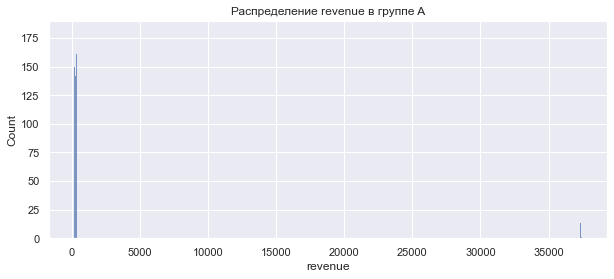

In [38]:
sns.set(rc={'figure.figsize':(10, 4)})
ax = sns.histplot(df_2.query('revenue > 0 & testgroup == "a"').revenue)
ax.set_title('Распределение revenue в группе A')

Видим заметные выбросы, взглянем подробнее

<AxesSubplot:xlabel='revenue', ylabel='Count'>

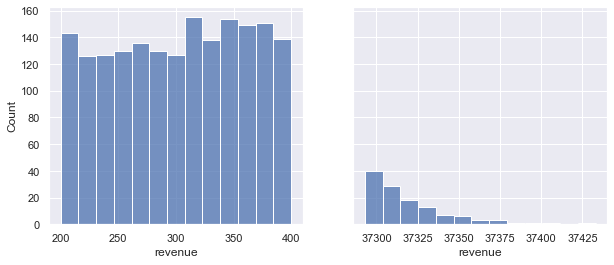

In [39]:
sns.set(rc={'figure.figsize':(10, 4)})
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.histplot(df_2.query('0 < revenue < 35000 & testgroup == "a"').revenue, ax=ax1)
sns.histplot(df_2.query('revenue > 35000 & testgroup == "a"').revenue, ax=ax2)

Интересно, посмотрим на распредение revenue в группе B:       
Видим, что в этом распределении заметных выбросов не наблюдается

Text(0.5, 1.0, 'Распределение revenue в группе A')

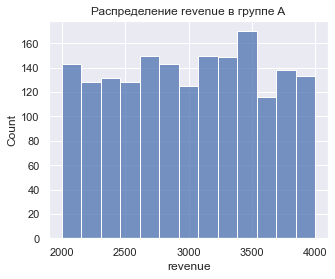

In [40]:
sns.set(rc={'figure.figsize':(5, 4)})
ax = sns.histplot(df_2.query('revenue > 0 & testgroup == "b"').revenue)
ax.set_title('Распределение revenue в группе A')

Для удобства можно сравнить по-перцентильно:

In [41]:
df_q = pd.DataFrame({
       'quantile': [0.05, 0.2, 0.4, "median", 0.6, 0.8, 0.95],
       'a': df_2.query('revenue > 0 & testgroup == "a"').revenue.quantile(q=[0.05, 0.2, 0.4, 0.5, 0.6, 0.8, 0.95]).values,
       'b': df_2.query('revenue > 0 & testgroup == "b"').revenue.quantile(q=[0.05, 0.2, 0.4, 0.5, 0.6, 0.8, 0.95]).values
                    })
df_q

,quantile,a,b
0,0.05,211.00,2094.0
1,0.2,246.00,2408.0
2,0.4,290.00,2810.2
3,median,311.00,3022.0
4,0.6,333.20,3211.0
5,0.8,372.60,3561.6
6,0.95,37299.65,3891.8


Видим, что до 95 перцентиля значения в группе B примерно в 10 раз больше, а потом - наоборот, в 10 меньше, интересно, похоже на значимые различия, но все гипотезы надо проверять!

Пару слов о том, как я намерен проверять гипотезы при помощи бутстрэпа      

> __Обладая только данными по имеющейся выборке, у нас есть возможность оценить любой её параметр, построив эмпирическое распределение параметра:__   

> __Cтроим бутстрап-распределения параметра в А и B - генерируем подвыборки одинакового размера беря(с возвращением) значения из каждой группый, cчитаем для получившихся двух подвыборок интересующие нас значения(например средние), повторяем нужное количество раз - получаем  бутстрап-распределения.__

> __Вычисляем их разницу (производим вычитание матриц) и для получившегося распределения разницы считаем доверительный интервал__    

> __Cогласно ЦПТ приняв правильность H0 полученное распределение должно иметь форму нормального со средним в нуле cответственно, если 0 попадает в доверительный интервал(или аналогично pvalue > 0.05), то нулевая гипотеза на заданном уровне значимости не отвергается (возможно принимается) и наоборот.__

### 2.2 Гипотеза о равенстве средних revenue со всех пользователей(ARPU)

Воспользуемся бутстрэпом, чтобы проверить 

\begin{equation*}
\begin{aligned} 
& H_0: \text{В двух группах одинаковый ARPU}   \\
& H_a: \text{В одной из 2х групп ARPU отличается}  \\
&      \text{и заодно выведем доверительные интервалы разницы этих различий, если они есть} 
\end{aligned}
\end{equation*}

In [42]:
gr_a = df_2.query('testgroup == "a"').revenue 
gr_b = df_2.query('testgroup == "b"').revenue


booted_data_1 = get_bootstrap(gr_a, gr_b, statistic = np.mean, boot_it = 1000)
get_pvalue(booted_data_1)

0.5550001209961766

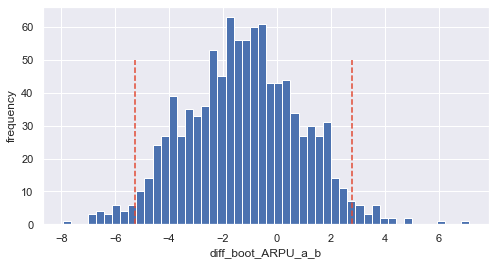

In [43]:
sns.set(rc={'figure.figsize':(8,4)})
plot_ci(booted_data_1)

plt.xlabel('diff_boot_ARPU_a_b')
plt.ylabel('frequency')
plt.show()

> __Гипотеза о равенстве ARPU на 5% уровне значимости принимается - статистически значимых различий между ARPU двух групп не обнаружено__

### 2.3 Гипотеза о равенстве средних revenue с платящих пользователей(ARPPU)

Воспользуемся бутстрэпом, чтобы проверить 

\begin{equation*}
\begin{aligned} 
& H_0: \text{В двух группах одинаковый ARPPU}   \\
& H_a: \text{В одной из 2х групп ARPPU отличается}  \\
&      \text{и заодно выведем доверительные интервалы разницы этих различий, если они есть} 
\end{aligned}
\end{equation*}

In [44]:
gr_a = df_2.query('revenue > 0 & testgroup == "a"').revenue
gr_b = df_2.query('revenue > 0 & testgroup == "b"').revenue
booted_data_2 = get_bootstrap(gr_a, gr_b, statistic = np.mean, boot_it = 1000)
get_pvalue(booted_data_2)

0.10287034696858548

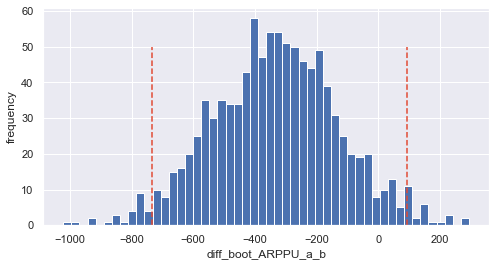

In [45]:
sns.set(rc={'figure.figsize':(8,4)})
plot_ci(booted_data_2)

plt.xlabel('diff_boot_ARPPU_a_b')
plt.ylabel('frequency')
plt.show()

> __Гипотеза о равенстве ARPPU на 5% уровне значимости принимается - статистически значимых различий между ARPU двух групп не обнаружено__


> __Вывод - если сравнивать при помощи бутстрэпа только средний revenue всех пользователей/платящих пользователей, то не будет выявлена значимая разница, попробуем сравнить другие величины__

### 2.4 Гипотеза о равенстве квантилей ARPPU

Зато если сравнивать медианту и другие квантили для платящих пользователей, то, вероятно, получится выявить значимые различия. Сравним [0.05, 0.2, 0.4, 0.5, 0.6, 0.8, 0.95] квантили при помощи бутстрэпа:

\begin{equation*}
\begin{aligned} 
& H_0: \text{В двух группах одинаковые квантили распределения ARPPU равны}   \\
& H_a: \text{В одной из 2х групп одинаковые квантили распределения ARPPU отличается}  \\
&      \text{и заодно выведем доверительные интервалы разницы этих различий, если они есть} 
\end{aligned}
\end{equation*}

In [46]:
gr_a = df_2.query('revenue > 0 & testgroup == "a"').revenue
gr_b = df_2.query('revenue > 0 & testgroup == "b"').revenue

q = quan_arppu(gr_a, gr_b)

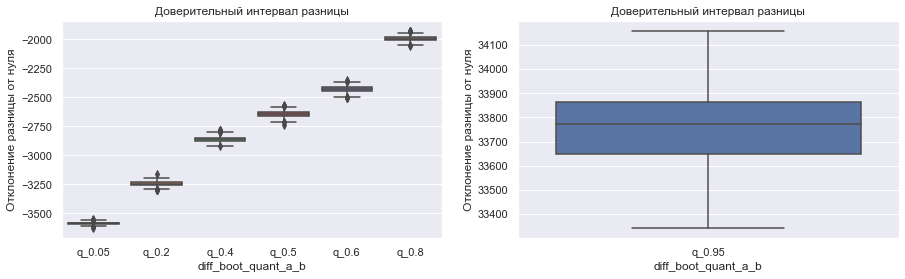

In [47]:
boot_q()

> __Видим, что всем этим распределениям далеко до 0(+ можно проверить через get_pvalue) -> в ГС есть различия между этими распределениями -> Гипотеза о равенстве квантилей ARPPU отклоняется, в группе B сумма покупки по большинству перцентилей больше, чем в группе A, зато в ней самые крупные покупки на значительно большую сумму.__

### 2.5 Гипотеза о равенстве CR в покупателя

\begin{equation*}
\begin{aligned} 
& H_0: \text{В двух группах одинаковое СR в покупателя}   \\
& H_a: \text{В одной из 2х групп СR в покупателя значимо отличается}  \\
&      \text{и заодно выведем доверительные интервалы разницы этих различий, если они есть} 
\end{aligned}
\end{equation*}

In [48]:
gr_a = df_2.query('testgroup == "a"').revenue.apply(lambda x: 1 if x > 0 else 0)
gr_b = df_2.query('testgroup == "b"').revenue.apply(lambda x: 1 if x > 0 else 0)

booted_data_2 = get_bootstrap(gr_a, gr_b, statistic = np.mean, boot_it = 1000)
get_pvalue(booted_data_2)

0.035365356169697756

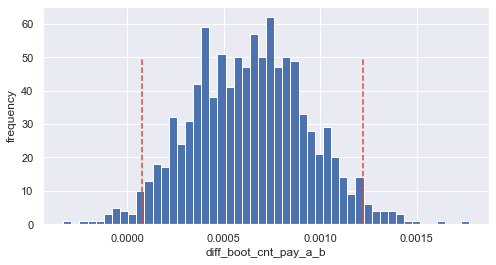

In [49]:
sns.set(rc={'figure.figsize':(8,4)})
plot_ci(booted_data_2)

plt.xlabel('diff_boot_cnt_pay_a_b')
plt.ylabel('frequency')
plt.show()

> __Гипотеза о равенстве СR в покупателя на 5% уровне значимости отвергается - обанаружены статистически значимые различия - в группе A СR в покупателя выше, чем в группе B__

>__А самое интересное заключается в том, что в A количество покупателей больше ровно на 123(1928 - 1805) человека, но ведь и самых крупных покупателей в этой группе как раз тоже 123 человека(как будто если бы генерировали доп данные для создания приблизительно равного ARPU)__

In [50]:
df_2.query('revenue > 35000 & testgroup == "a"').user_id.nunique()

123

In [51]:
df_2.query('revenue > 0 & testgroup == "a"').shape[0] - df_2.query('revenue > 0 & testgroup == "b"').shape[0]

123

### 2.6 Выводы и теории
>_Для начала я считаю важным исключить возможность ошибки - появления крупных покупателей в группе A - из-за какого-то бага при сборе и хранении данных revenue может умножаться в 100 раз, а на самом деле они все небольшие(к тому же в группе A больше на 123 человека и ровно 123 человека имеют огромные чеки -  похоже на сбой)._

>_Также нужно проверить валидность парсинга данных(для этого удобнее применять A/A/B тестирование), чтобы исключить возможность попадания людей из какго-то диапазона revenue только в одну из групп._

>_Если крупные покупки в группе А - это не сбой, хорошо было бы определить природу появления крупных покупателей - посмотреть время их покупок, активность их аккаунта, - это может могли быть единичные случаи или закономерность. Аналогично нужно выяснить, почему таких крупных покупателей не было в группе B(если в теории в проведенной акции это возможно)_

>__Итого, при наличии времени желательно удостовариться(возможно и при помощи продления эксперимента и сбора бОльших данных):     
1)Что в группе А и правда есть крупные покупатели       
2)Что в группе B не появятся(если могут) крупные покупатели        
3)Что в группе A и правда бОльшее число покупателей(сейчас больше ровно на количество крупных)__

>__Если принять, что эксперимент был проведен правильно и были как-то подтверждены предположения о корретности наших данных(и не случайности крупных покупателей в A), то различия между доходом(на пользователя и общим) в двух группах можно считать статистически незначимыми, зато нашлись опять же значимые различия в СR покупателей, в группе A он больше.__

>__А далее, если все корректно и если считать ARPU и ARPPU равными, уже можно отталкиваться от того, сколько и какие платящие пользователи нам нужны, анализировать, сможем ли мы привлечь больше крупных покупателей(это большие фанаты игры или небедные новички и т.д.) или выгоднее будет привлекать большее количество средних покупателей...__

## 3. Выбор метрик для оценки результатов тематических ежемесячных событий
[Содержание](#Содержание)

### Выполнение:

Для оценки тематического события в голову сразу приходит большое количетсво метрик, но для начала нужно понять, какой результат мы хотим оценить, или, другими словами - какая была цель проведения нашего тематического события. Предположу, что основными задачами было - повысить лояльность целевой аудитории, увеличить дневной онлайн, возможно - повысить узнаваемость игры за счет того, что в игре появился новый контент и об этом можно говорить(как людям между собой, так и в рекламе). Возможно еще заодно можно увеличить прибыль, продав косметические товары тематического события(вместо того, чтобы проходить уровни, будет возможность купить тематический товар). Также, раз мы измеряем лояльность игроков, можно посмотреть на их достижения во время этого события(кто сколько прошел, сколько нафармил, остался ли доволен, может донатил больше, может меньше и т.д.).

Выделю главные метрики и ниже опишу подробнее

>__DAU, ASL(средняя продолжительность сессии),        
CR в участие и в полное прохождение события, Retention в событии и после него,     
ARPU и ARPPU u количесство платящих пользователей__

И подробнее - в приведенных выше задачах могут помочь следующие показатели:

#### 1. Временные метрики аудитории  

>Полезно будет знать, вырос ли общий онлайн в игре(DAU, WAU, за весь период); увеличился ли retention - на сколько и для каких сегметнов аудитории(старички-фаны, новички, обычные) и, в том числе, участвовали ли в событии каждый день(например в событии дейлик на прохождение этих уровней за время); стало ли больше новых регистраций. Можно посмотреть на количество сессий игроков за день и общее количество времени, проведенное в день в игре. Интересно узнать сколько времени игроки тратят на разные уровни, чтобы посмотрев еще на конверсию понять, где игрок проходит уровни легко, а где у него возникают затруднения. Можно проверить, меняется ли retention игроков, участвующих в событии после его завершения.
>
> По этим критериям можно увидеть в том числе и изменение вовлеченности, а она косвенно будет влиять и на лояльнось - чем больше нравится, тем больше играешь(в разумных пределах). 


#### 2. Метрики конверсии аудитории    

>Неплохо узнать, какому проценту пользователей было интересно наше тематическое событие(какая была конверсия в участие); до какого уровня в среднем доходят игроки и какой процент проходит все событие полностью. У игроков, которые не могут пройти событие до конца, хорошо бы узнать, кто эти игроки и почему у них не получилось(например, если это не так просто и для этого заранее уже требовалось играть, иметь какой-то "прокачанный" сад и персонажей или на это требуется очень много игрового и реального времени).   
>
>По этим показателям тоже можно косвенно видеть удовлетворенность событием, а значит и лояльность аудитории.


#### 3. Валютные метрики

>Сколько в среднем игроки получили бонусов и не сломало ли это игру, не получил ли кто-то аномально много бонусов "заабузив" механику тематического события(если да - разобраться и откатить). Какие бонусы игроки выбирали чаще всего и куда тратили - можно узнать, например, самые востребованные предметы события. 
>
>Аналогично можно вернуться в рельный мир и узнать, вырос ли ARPU и ARPPU(и какой процент от донатов в событие в этом росте), увеличилась ли конверсия в покупку(и в какую - тематических предметов события или вообще). Интерсно будет узнать, как поведут себя пользователи с нетематическими покупками: для прохождения события и получения заветных предметов, например, надо иметь прокачанный сад, а он есть не у всех, поэтому люди будут донатить, потому что это стало выгоднее(и заданатил в сад, и бонус события получил). Или наоборот донатов будет меньше, потому что и так дают награды за прохождения уровней, и зачем еще донатить...
>
> С помощью этих метрик тоже можно отследить вовлеченность + косвенно, по количеству покупок, понять и отношение пользователей, узнать доход компании от тематического события.


#### 4. Метрики работоспособности

>В дополнение к анализу конверсий и времени в игре можно комплексно посмотреть, вдруг где-то в игре что-то не рабоает, а этого еще не заметили - очень долгая загрузка и пользователь уходит не дожидаясь; никто уровень пройти не может, ведь там что-то сломано; пользователя выбрасывает из игры и он совершает очень много перезаходов, и отчаявшись, он не заходит в игру или в тематическое событие вообще и т.п.
>
>Работоспособность на восприятие игры влияет и очень сильно, а значит и на лояльность и на конверсию в покупку


#### 5. Дополнение про метрики лояльности

>Можно читать отзывы, смотреть их на отдельных новостных ресурсах от комментариев и лайков в магазине с игрой до комментариев и лайков под видеообзорами с гемплеем события на твиче или ютубе. Интересно также узнать, стали ли пользователи чаще делиться достижениями в игре в социальных сетях или реферальными сссылками среди друзей.

Если мы усложним механику метрики кардинально не изменятся, но надо будет точнее следить за сложностью уровней(на каких уровнях разные игроки чаще всего откатываются)(через конверсию в каждый следующий уровень, DAU и общий retention игроков), чтобы балансировать одновременно и настроение аудитории(которая хочет получить бонусов и побольше и не хочет много проигрывать и откатываться назад) и количество игроков, которые получат много бонусов(чтобы не сломать экономику игры и не сделать донат бесполезным). 

Соответственно можно добавить метрику, например, после какого количества неудачных попыток пользователь уходит из события и предлагать ему перед этим какие-то бонусы или снижать сложность. Или еще метрику - как долго пользователь не может пройти определенный уровень и после некоторго значения тоже предлагать какие-то бонусы и т.п.

[Содержание](#Содержание)